In [5]:
import os
import json
import warnings
warnings.filterwarnings('ignore')

In [ ]:
METADATA_PATH = '../UrbanSound8K/metadata/UrbanSound8K.csv'
AUDIO_BASE_PATH = '../UrbanSound8K/audio'

In [7]:
def load_fold_paths(data_cache_dir):
    """
    Returns:
      train_paths[fold] = [list of paths]
      train_labels[fold] = [list of labels]
    """
    train_paths = {}
    train_labels = {}

    test_paths = {}
    test_labels = {}

    for f in range(1, 11):

        train_dir = os.path.join(data_cache_dir, f"fold_{f}", "train")
        with open(os.path.join(train_dir, "labels.json"), "r") as fjson:
            labels = json.load(fjson)

        paths = [
            os.path.join(train_dir, fname)
            for fname in sorted(os.listdir(train_dir))
            if fname.endswith(".npy")
        ]

        train_paths[f] = paths
        train_labels[f] = labels

        test_dir = os.path.join(data_cache_dir, f"fold_{f}", "test")
        with open(os.path.join(test_dir, "labels.json"), "r") as fjson:
            labels = json.load(fjson)

        paths = [
            os.path.join(test_dir, fname)
            for fname in sorted(os.listdir(test_dir))
            if fname.endswith(".npy")
        ]

        test_paths[f] = paths
        test_labels[f] = labels

    return train_paths, train_labels, test_paths, test_labels

In [8]:
import numpy as np
import torch

from sklearn.metrics import accuracy_score
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [9]:
class AudioDataset(Dataset):
    """
    Dataset class for audio data
    """
    def __init__(self, audio_data, labels, transform=None):
        """
        Parameters:
        -----------
        audio_data : list or np.ndarray
            List of audio arrays
        labels : list or np.ndarray
            Corresponding labels
        transform : callable, optional
            Optional transform to apply
        """
        self.audio_data = audio_data
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.audio_data)
    
    def __getitem__(self, idx):
        audio = self.audio_data[idx]
        label = self.labels[idx]
        
        # Convert to tensor if not already
        if not isinstance(audio, torch.Tensor):
            audio = torch.FloatTensor(audio)
        
        if not isinstance(label, torch.Tensor):
            label = torch.LongTensor([label])[0]
        
        if self.transform:
            audio = self.transform(audio)
        
        return audio, label

In [10]:
def evaluate_model(model, test_dataset, batch_size=32, device=None, metrics=None):
    """
    Evaluate model on test dataset
    
    Parameters:
    -----------
    model : nn.Module
        Trained model
    test_dataset : Dataset or dict
        Test dataset
    batch_size : int
        Batch size
    device : str or torch.device, optional
        Device to use
    metrics : list of callable, optional
        Metrics to compute
    
    Returns:
    --------
    dict : Evaluation results
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Convert dict to Dataset if needed
    if isinstance(test_dataset, dict):
        test_dataset = AudioDataset(test_dataset['audio'], test_dataset['labels'])
    
    # Create data loader
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )
    
    # Setup metrics
    if metrics is None:
        metrics = [accuracy_score]
    
    model.eval()
    total_metrics = np.zeros(len(metrics))
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Evaluating'):
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            
            # Track metrics
            for i, metric in enumerate(metrics):
                total_metrics[i] += metric(output, target)
            
            # Store predictions
            pred = torch.argmax(output, dim=1)
            all_predictions.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    # Calculate average metrics
    avg_metrics = total_metrics / len(test_loader)
    
    results = {
        'predictions': np.array(all_predictions),
        'targets': np.array(all_targets)
    }
    
    for i, metric in enumerate(metrics):
        metric_name = metric.__name__ if hasattr(metric, '__name__') else f'metric_{i}'
        results[metric_name] = avg_metrics[i]
    
    print("\nEvaluation Results:")
    print("=" * 40)
    for i, metric in enumerate(metrics):
        metric_name = metric.__name__ if hasattr(metric, '__name__') else f'metric_{i}'
        print(f"{metric_name}: {avg_metrics[i]:.4f}")
    print("=" * 40)
    
    return results

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os

from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import Spectrogram, MelSpectrogram, TimeStretch, AmplitudeToDB
from torch.distributions import Uniform
from tqdm import tqdm
from collections import defaultdict

In [12]:
def _num_stft_bins(lengths, fft_length, hop_length, pad):
    return (lengths + 2 * pad - fft_length + hop_length) // hop_length

class RandomTimeStretch(TimeStretch):
    def __init__(self, max_perc, hop_length=None, n_freq=201, fixed_rate=None):
        super(RandomTimeStretch, self).__init__(hop_length, n_freq, fixed_rate)
        self._dist = Uniform(1.-max_perc, 1+max_perc)

    def forward(self, x):
        rate = self._dist.sample().item()
        return super(RandomTimeStretch, self).forward(x, rate), rate

class SpecNormalization(nn.Module):
    def __init__(self, norm_type, top_db=80.0):
        super(SpecNormalization, self).__init__()

        if 'db' == norm_type:
            self._norm = AmplitudeToDB(stype='power', top_db=top_db)
        elif 'whiten' == norm_type:
            self._norm = lambda x: self.z_transform(x)
        else:
            self._norm = lambda x: x
        
    def z_transform(self, x):
        # Independent mean, std per batch
        non_batch_inds = [1, 2, 3]
        mean = x.mean(non_batch_inds, keepdim=True)
        std = x.std(non_batch_inds, keepdim=True)
        x = (x - mean)/std 
        return x

    def forward(self, x):
        return self._norm(x)

class MelspectrogramStretch(MelSpectrogram):
    def __init__(self, hop_length=None, 
                       sample_rate=44100, 
                       num_mels=128, 
                       fft_length=2048, 
                       norm='whiten', 
                       stretch_param=[0.4, 0.4]):

        super(MelspectrogramStretch, self).__init__(sample_rate=sample_rate, 
                                                    n_fft=fft_length, 
                                                    hop_length=hop_length, 
                                                    n_mels=num_mels)

        self.stft = Spectrogram(n_fft=self.n_fft, win_length=self.win_length,
                                       hop_length=self.hop_length, pad=self.pad, 
                                       power=None, normalized=False)

        # Augmentation
        self.prob = stretch_param[0]
        self.random_stretch = RandomTimeStretch(stretch_param[1], 
                                                self.hop_length, 
                                                self.n_fft//2+1, 
                                                fixed_rate=None)
        
        # Normalization (post spec processing)
        self.complex_norm = lambda x: torch.abs(x).pow(2.0)
        self.norm = SpecNormalization(norm)

    def forward(self, x, lengths=None):
        x = self.stft(x)

        if lengths is not None:
            lengths = _num_stft_bins(lengths, self.n_fft, self.hop_length, self.n_fft//2)
            lengths = lengths.long()
        
        if torch.rand(1)[0] <= self.prob and self.training:
            # Stretch spectrogram in time using Phase Vocoder
            x, rate = self.random_stretch(x)
            # Modify the rate accordingly
            lengths = (lengths.float()/rate).long()+1
        
        x = self.complex_norm(x)
        x = self.mel_scale(x)

        # Normalize melspectrogram
        x = self.norm(x)

        if lengths is not None:
            return x, lengths        
        return x

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [13]:
class AudioRNN(nn.Module):
    def __init__(self, num_classes=10, config=None):
        super(AudioRNN, self).__init__()
        
        self.num_classes = num_classes
        self.config = config if config else {}
        
        # Spectrogram parameters
        self.sample_rate = self.config.get('sample_rate', 22050)
        self.num_mels = self.config.get('num_mels', 128)
        self.fft_length = self.config.get('fft_length', 2048)
        self.hop_length = self.config.get('hop_length', 512)
        
        # Melspectrogram transform
        self.spec = MelspectrogramStretch(
            hop_length=self.hop_length,
            sample_rate=self.sample_rate,
            num_mels=self.num_mels,
            fft_length=self.fft_length,
            norm=self.config.get('norm', 'whiten'),
            stretch_param=self.config.get('stretch_param', [0.4, 0.4])
        )
        
        # RNN parameters
        self.hidden_size = self.config.get('hidden_size', 64)
        self.num_layers = self.config.get('num_layers', 2)
        self.bidirectional = self.config.get('bidirectional', False)
        self.rnn_dropout = self.config.get('rnn_dropout', 0.1)
        
        # Build LSTM
        self.lstm = nn.LSTM(
            input_size=self.num_mels,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            bidirectional=self.bidirectional,
            dropout=self.rnn_dropout if self.num_layers > 1 else 0.0,
            batch_first=True
        )
        
        # Dense layer parameters
        lstm_output_size = self.hidden_size * (2 if self.bidirectional else 1)
        self.dropout_p = self.config.get('dropout', 0.3)
        
        # Build dense layers
        self.dense = nn.Sequential(
            nn.Dropout(self.dropout_p),
            nn.LayerNorm(lstm_output_size),
            nn.Linear(lstm_output_size, num_classes)
        )
    
    def _many_to_one(self, t, lengths):
        """Extract last relevant output for each sequence"""
        return t[torch.arange(t.size(0)), lengths - 1]
    
    def forward(self, x, lengths=None):
        """
        Args:
            x: (batch, time) audio waveform
            lengths: (batch,) sequence lengths
        """
        # Ensure correct shape
        if x.dim() == 2:
            x = x.unsqueeze(1)  # (batch, 1, time)
        
        # Spectrogram: (batch, channel, freq, time)
        x, lengths = self.spec(x, lengths)
        
        # Transpose to (batch, time, channel, freq)
        x = x.transpose(1, -1)
        batch_size, time = x.size()[:2]
        
        # Flatten: (batch, time, features)
        x = x.reshape(batch_size, time, -1)
        
        # Pack padded sequence
        x_pack = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        # LSTM
        x_pack, _ = self.lstm(x_pack)
        
        # Unpack
        x, _ = nn.utils.rnn.pad_packed_sequence(x_pack, batch_first=True)
        
        # Many-to-one
        x = self._many_to_one(x, lengths)
        
        # Dense layers
        x = self.dense(x)
        
        return F.log_softmax(x, dim=1)

class LazyAudioRNNDataset(Dataset):
    def __init__(self, audio_paths, labels):
        """
        audio_paths : list of file paths to .npy audio files
        labels      : list/array of labels (string or int)
        """
        self.audio_paths = audio_paths

        labels = np.array(labels)

        if labels.dtype.kind in ['U', 'S', 'O']:
            unique_labels = np.unique(labels)
            self.label_to_idx = {label: idx for idx, label in enumerate(sorted(unique_labels))}
            self.labels = np.array([self.label_to_idx[l] for l in labels], dtype=np.int64)
            print(f"Converted string labels to integers: {self.label_to_idx}")

        else:
            self.labels = labels.astype(np.int64)

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        # ---- Lazy load from .npy instead of loading everything in RAM ----
        audio = np.load(self.audio_paths[idx], mmap_mode="r")

        label = self.labels[idx]

        if not isinstance(audio, torch.Tensor):
            audio = torch.FloatTensor(audio)

        if audio.dim() > 1:
            audio = audio.squeeze()

        if not isinstance(label, torch.Tensor):
            label = torch.tensor(label, dtype=torch.long)

        return audio, label

In [14]:
import json

class TrainingHistory:
    def __init__(self):
        self.history = defaultdict(list)
    
    def add(self, key, value):
        self.history[key].append(value)
    
    def plot(self, save_path=None):
        metrics = list(self.history.keys())
        n_metrics = len(metrics)
        
        fig, axes = plt.subplots(1, n_metrics, figsize=(5*n_metrics, 4))
        if n_metrics == 1:
            axes = [axes]
        
        for idx, metric in enumerate(metrics):
            values = self.history[metric]
            axes[idx].plot(values, marker='o', linewidth=2)
            axes[idx].set_title(metric.replace('_', ' ').title(), fontsize=12, fontweight='bold')
            axes[idx].set_xlabel('Epoch', fontsize=10)
            axes[idx].set_ylabel('Value', fontsize=10)
            axes[idx].grid(alpha=0.3)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()
    
    def get_best(self, metric, mode='max'):
        values = self.history[metric]
        if mode == 'max':
            best_value = max(values)
            best_epoch = values.index(best_value) + 1
        else:
            best_value = min(values)
            best_epoch = values.index(best_value) + 1
        return best_value, best_epoch
    
    def save(self, path):
        """Save history to file"""
        with open(path, 'w') as f:
            json.dump(dict(self.history), f, indent=2)

In [15]:
def collate_fn_rnn(batch):
    """
    Input: List of (audio, label) tuples from dataset
    Output: Padded batch ready for RNN
    """
    audios, labels = zip(*batch)  # Separate audio and labels
    
    # 1. Get actual lengths of each audio
    lengths = torch.LongTensor([len(a) for a in audios])
    # Example: [44100, 88200, 22050]
    
    # 2. Pad all audios to the same length (longest in batch)
    padded_audio = nn.utils.rnn.pad_sequence(audios, batch_first=True)
    # Example shape: (3, 88200) - all padded to longest (88200)
    
    # 3. Stack labels
    labels = torch.stack(labels)
    
    return padded_audio, lengths, labels

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(cm, save_path=None, title='Confusion Matrix', normalize=False):
    """Plot confusion matrix"""
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', cbar=True)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

def plot_fold_accuracies(accuracies, save_path=None):
    """Plot accuracy across folds"""
    
    plt.figure(figsize=(10, 6))
    folds = list(range(1, len(accuracies) + 1))
    
    plt.plot(folds, accuracies, marker='o', linewidth=2, markersize=8, color='steelblue')
    plt.axhline(y=np.mean(accuracies), color='red', linestyle='--', 
                label=f'Mean: {np.mean(accuracies):.4f}')
    
    plt.xlabel('Fold', fontsize=12)
    plt.ylabel('Test Accuracy', fontsize=12)
    plt.title('Test Accuracy Across 10 Folds', fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.xticks(folds)
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    
def plot_all_metrics_across_folds(fold_results, save_path=None):
    """Plot accuracy, precision, recall, and F1-score across folds."""

    # Extract metrics
    accuracies = [fr['test_accuracy'] for fr in fold_results]
    precision_macro = [fr['test_precision_macro'] for fr in fold_results]
    recall_macro = [fr['test_recall_macro'] for fr in fold_results]
    f1_macro = [fr['test_f1_macro'] for fr in fold_results]

    folds = list(range(1, len(fold_results) + 1))

    plt.figure(figsize=(12, 8))

    # Plot each metric
    plt.plot(folds, accuracies, marker='o', linewidth=2, label='Accuracy')
    plt.plot(folds, precision_macro, marker='o', linewidth=2, label='Precision (Macro)')
    plt.plot(folds, recall_macro, marker='o', linewidth=2, label='Recall (Macro)')
    plt.plot(folds, f1_macro, marker='o', linewidth=2, label='F1 Score (Macro)')

    # Add mean horizontal lines
    plt.axhline(np.mean(accuracies), linestyle='--', linewidth=1,
                label=f"Mean Accuracy: {np.mean(accuracies):.4f}")
    plt.axhline(np.mean(precision_macro), linestyle='--', linewidth=1,
                label=f"Mean Precision(M): {np.mean(precision_macro):.4f}")
    plt.axhline(np.mean(recall_macro), linestyle='--', linewidth=1,
                label=f"Mean Recall(M): {np.mean(recall_macro):.4f}")
    plt.axhline(np.mean(f1_macro), linestyle='--', linewidth=1,
                label=f"Mean F1(M): {np.mean(f1_macro):.4f}")

    # Labels and formatting
    plt.xlabel("Fold", fontsize=12)
    plt.ylabel("Metric Value", fontsize=12)
    plt.title("Performance Metrics Across Folds", fontsize=14, fontweight='bold')
    plt.xticks(folds)
    plt.grid(alpha=0.3)
    plt.legend()
    
    # Save and show
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

In [17]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

def compute_metrics(predictions, targets, num_classes=10):
    """
    Compute comprehensive metrics
    
    Parameters:
    -----------
    predictions : array-like
        Predicted labels
    targets : array-like
        True labels
    num_classes : int
        Number of classes
    
    Returns:
    --------
    dict : Dictionary with all metrics
    """
    # Accuracy
    accuracy = (np.array(predictions) == np.array(targets)).mean()
    
    # Precision, Recall, F1 (macro and weighted)
    precision_macro = precision_score(targets, predictions, average='macro', zero_division=0)
    precision_weighted = precision_score(targets, predictions, average='weighted', zero_division=0)
    
    recall_macro = recall_score(targets, predictions, average='macro', zero_division=0)
    recall_weighted = recall_score(targets, predictions, average='weighted', zero_division=0)
    
    f1_macro = f1_score(targets, predictions, average='macro', zero_division=0)
    f1_weighted = f1_score(targets, predictions, average='weighted', zero_division=0)
    
    # Per-class metrics
    precision_per_class = precision_score(targets, predictions, average=None, zero_division=0, labels=range(num_classes))
    recall_per_class = recall_score(targets, predictions, average=None, zero_division=0, labels=range(num_classes))
    f1_per_class = f1_score(targets, predictions, average=None, zero_division=0, labels=range(num_classes))
    
    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_per_class': precision_per_class.tolist(),
        'recall_per_class': recall_per_class.tolist(),
        'f1_per_class': f1_per_class.tolist()
    }

def print_metrics(metrics, prefix=""):
    """Print metrics in a formatted way"""
    print(f"\n{prefix}Metrics:")
    print(f"  Accuracy:          {metrics['accuracy']:.4f}")
    print(f"  Precision (macro): {metrics['precision_macro']:.4f}")
    print(f"  Recall (macro):    {metrics['recall_macro']:.4f}")
    print(f"  F1-Score (macro):  {metrics['f1_macro']:.4f}")
    print(f"  Precision (wtd):   {metrics['precision_weighted']:.4f}")
    print(f"  Recall (wtd):      {metrics['recall_weighted']:.4f}")
    print(f"  F1-Score (wtd):    {metrics['f1_weighted']:.4f}")

In [ ]:
import json
import numpy as np
import gc
import torch

from datetime import datetime

def train_audio_rnn_cross_validation(
    data_cache_dir,
    config,
    epochs=20,
    batch_size=32,
    lr=0.001,
    device=None,
    num_classes=10
):
    """
    10-Fold Cross-Validation Pipeline for UrbanSound8K
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"Initial GPU memory allocated: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
    
    train_paths, train_labels, test_paths, test_labels = load_fold_paths(data_cache_dir=data_cache_dir)
    
    timestamp = datetime.now().strftime("%m%d_%H%M%S")
    save_dir = f"../saved_cv/{timestamp}"
    os.makedirs(save_dir, exist_ok=True)
    print(f"Save directory: {save_dir}")
    
    with open(os.path.join(save_dir, 'config.json'), 'w') as f:
        json.dump(config, f, indent=2)
    
    fold_results = []
    all_fold_accuracies = []
    cumulative_confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    
    print("\n" + "="*60)
    print("10-FOLD CROSS-VALIDATION")
    print("="*60)
    print("Scheme: 1 fold test, 1 fold validation, 8 folds training")
    print("="*60)
    
    for test_fold in range(1, 11):
        val_fold = (test_fold % 10) + 1
        train_folds = [f for f in range(1, 11) if f != test_fold and f != val_fold]
        
        print(f"\n{'='*60}")
        print(f"FOLD {test_fold}/10")
        print(f"{'='*60}")
        print(f"Test fold: {test_fold}")
        print(f"Validation fold: {val_fold}")
        print(f"Training folds: {train_folds}")
        
        fold_dir = os.path.join(save_dir, f'fold_{test_fold}')
        os.makedirs(fold_dir, exist_ok=True)
        
        print("\n" + "="*60)
        print("STEP 1: Loading Data from Cache")
        print("="*60)

        X_train = sum((train_paths[f] for f in train_folds), [])
        y_train = sum((train_labels[f] for f in train_folds), [])

        X_val = test_paths[val_fold]
        y_val = test_labels[val_fold]

        X_test = test_paths[test_fold]
        y_test = test_labels[test_fold]

        train_dataset = LazyAudioRNNDataset(X_train, y_train)
        val_dataset   = LazyAudioRNNDataset(X_val, y_val)
        test_dataset  = LazyAudioRNNDataset(X_test, y_test)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn_rnn)
        val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn_rnn)
        test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn_rnn)
        
        print("\n" + "="*60)
        print("STEP 2: Creating Model")
        print("="*60)
        
        model = AudioRNN(num_classes=num_classes, config=config)
        model = model.to(device)
        
        total_params = sum(p.numel() for p in model.parameters())
        print(f"Total parameters: {total_params:,}")
        
        if torch.cuda.is_available():
            print(f"GPU memory after model creation: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
        
        print("\n" + "="*60)
        print("STEP 3: Training Model")
        print("="*60)
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        history = TrainingHistory()
        
        best_val_loss = float('inf')
        best_val_acc = 0.0
        
        for epoch in range(1, epochs + 1):
            print(f"\nEpoch {epoch}/{epochs}")
            print("-" * 40)
            
            model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            
            train_pbar = tqdm(train_loader, desc='Training', leave=False)
            for batch_idx, (audio, lengths, labels) in enumerate(train_pbar):
                audio = audio.to(device)
                lengths = lengths.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(audio, lengths)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                pred = outputs.argmax(dim=1)
                train_correct += (pred == labels).sum().item()
                train_total += labels.size(0)
                
                train_pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{train_correct/train_total:.4f}'
                })
                
                if batch_idx % 50 == 0 and torch.cuda.is_available():
                    torch.cuda.empty_cache()
            
            avg_train_loss = train_loss / len(train_loader)
            train_acc = train_correct / train_total
            
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                val_pbar = tqdm(val_loader, desc='Validation', leave=False)
                for audio, lengths, labels in val_pbar:
                    audio = audio.to(device)
                    lengths = lengths.to(device)
                    labels = labels.to(device)
                    
                    outputs = model(audio, lengths)
                    loss = criterion(outputs, labels)
                    
                    val_loss += loss.item()
                    pred = outputs.argmax(dim=1)
                    val_correct += (pred == labels).sum().item()
                    val_total += labels.size(0)
                    
                    val_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
            
            avg_val_loss = val_loss / len(val_loader)
            val_acc = val_correct / val_total
            
            history.add('train_loss', avg_train_loss)
            history.add('train_accuracy', train_acc)
            history.add('val_loss', avg_val_loss)
            history.add('val_accuracy', val_acc)
            
            print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
            
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_val_acc = val_acc
                torch.save({
                    'fold': test_fold,
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': best_val_loss,
                    'val_acc': best_val_acc,
                    'config': config
                }, os.path.join(fold_dir, 'best_model.pth'))
            
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        print("\n" + "="*60)
        print("STEP 4: Testing on Held-Out Fold")
        print("="*60)
        
        checkpoint = torch.load(os.path.join(fold_dir, 'best_model.pth'))
        model.load_state_dict(checkpoint['model_state_dict'])
        
        model.eval()
        test_loss = 0
        test_correct = 0
        test_total = 0
        
        all_predictions = []
        all_targets = []
        
        with torch.no_grad():
            test_pbar = tqdm(test_loader, desc='Testing')
            for audio, lengths, labels in test_pbar:
                audio = audio.to(device)
                lengths = lengths.to(device)
                labels = labels.to(device)
                
                outputs = model(audio, lengths)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                pred = outputs.argmax(dim=1)
                test_correct += (pred == labels).sum().item()
                test_total += labels.size(0)
                
                all_predictions.extend(pred.cpu().numpy())
                all_targets.extend(labels.cpu().numpy())
                
                test_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        avg_test_loss = test_loss / len(test_loader)
        test_acc = test_correct / test_total
        
        print(f"\nTest Loss: {avg_test_loss:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")
        
        test_metrics = compute_metrics(all_predictions, all_targets, num_classes)
        print_metrics(test_metrics, prefix="Test ")
        
        fold_confusion_matrix = confusion_matrix(all_targets, all_predictions, labels=range(num_classes))
        cumulative_confusion_matrix += fold_confusion_matrix
        
        fold_result = {
            'fold': test_fold,
            'test_fold': test_fold,
            'val_fold': val_fold,
            'train_folds': train_folds,
            'test_loss': avg_test_loss,
            'test_accuracy': test_metrics['accuracy'],
            'test_precision_macro': test_metrics['precision_macro'],
            'test_precision_weighted': test_metrics['precision_weighted'],
            'test_recall_macro': test_metrics['recall_macro'],
            'test_recall_weighted': test_metrics['recall_weighted'],
            'test_f1_macro': test_metrics['f1_macro'],
            'test_f1_weighted': test_metrics['f1_weighted'],
            'test_precision_per_class': test_metrics['precision_per_class'],
            'test_recall_per_class': test_metrics['recall_per_class'],
            'test_f1_per_class': test_metrics['f1_per_class'],
            'best_val_accuracy': best_val_acc,
            'best_val_loss': best_val_loss,
            'confusion_matrix': fold_confusion_matrix.tolist()
        }
        fold_results.append(fold_result)
        all_fold_accuracies.append(test_acc)
        
        with open(os.path.join(fold_dir, 'fold_results.json'), 'w') as f:
            json.dump(fold_result, f, indent=2)
        
        class_names = [f'Class_{i}' for i in range(num_classes)]
        report = classification_report(all_targets, all_predictions, 
                                      target_names=class_names, 
                                      digits=4)
        with open(os.path.join(fold_dir, 'classification_report.txt'), 'w') as f:
            f.write(f"Classification Report - Fold {test_fold}\n")
            f.write("="*60 + "\n")
            f.write(report)
        
        history.save(os.path.join(fold_dir, 'history.json'))
        history.plot(save_path=os.path.join(fold_dir, 'training_curves.png'))
        
        plot_confusion_matrix(
            fold_confusion_matrix,
            save_path=os.path.join(fold_dir, 'confusion_matrix.png'),
            title=f'Confusion Matrix - Fold {test_fold}'
        )
        
        print(f"\nFold {test_fold} completed!")
        print(f"Results saved to: {fold_dir}")
        
        del train_loader, val_loader, test_loader
        gc.collect()  # Force garbage collection immediately after deleting loaders
        
        del train_dataset, val_dataset, test_dataset
        
        del model, optimizer, criterion, history
        del all_predictions, all_targets
        del checkpoint  
        
        gc.collect()
        gc.collect()  # Call twice for good measure
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()  # Wait for GPU operations to complete

        plt.close('all')
        
    print("\n" + "="*60)
    print("CROSS-VALIDATION RESULTS")
    print("="*60)
    
    mean_accuracy = np.mean([r['test_accuracy'] for r in fold_results])
    std_accuracy = np.std([r['test_accuracy'] for r in fold_results])
    
    mean_precision_macro = np.mean([r['test_precision_macro'] for r in fold_results])
    std_precision_macro = np.std([r['test_precision_macro'] for r in fold_results])
    
    mean_recall_macro = np.mean([r['test_recall_macro'] for r in fold_results])
    std_recall_macro = np.std([r['test_recall_macro'] for r in fold_results])
    
    mean_f1_macro = np.mean([r['test_f1_macro'] for r in fold_results])
    std_f1_macro = np.std([r['test_f1_macro'] for r in fold_results])
    
    mean_precision_weighted = np.mean([r['test_precision_weighted'] for r in fold_results])
    std_precision_weighted = np.std([r['test_precision_weighted'] for r in fold_results])
    
    mean_recall_weighted = np.mean([r['test_recall_weighted'] for r in fold_results])
    std_recall_weighted = np.std([r['test_recall_weighted'] for r in fold_results])
    
    mean_f1_weighted = np.mean([r['test_f1_weighted'] for r in fold_results])
    std_f1_weighted = np.std([r['test_f1_weighted'] for r in fold_results])
    
    print(f"\nMetrics per fold:")
    print(f"{'Fold':<6} {'Acc':<8} {'Prec(M)':<10} {'Rec(M)':<10} {'F1(M)':<10}")
    print("-" * 50)
    for i, result in enumerate(fold_results, 1):
        print(f"{i:<6} {result['test_accuracy']:<8.4f} "
              f"{result['test_precision_macro']:<10.4f} "
              f"{result['test_recall_macro']:<10.4f} "
              f"{result['test_f1_macro']:<10.4f}")
    
    print("\n" + "="*60)
    print("AGGREGATE RESULTS (Mean ± Std)")
    print("="*60)
    print(f"Accuracy:              {mean_accuracy:.4f} ± {std_accuracy:.4f}")
    print(f"Precision (macro):     {mean_precision_macro:.4f} ± {std_precision_macro:.4f}")
    print(f"Recall (macro):        {mean_recall_macro:.4f} ± {std_recall_macro:.4f}")
    print(f"F1-Score (macro):      {mean_f1_macro:.4f} ± {std_f1_macro:.4f}")
    print(f"Precision (weighted):  {mean_precision_weighted:.4f} ± {std_precision_weighted:.4f}")
    print(f"Recall (weighted):     {mean_recall_weighted:.4f} ± {std_recall_weighted:.4f}")
    print(f"F1-Score (weighted):   {mean_f1_weighted:.4f} ± {std_f1_weighted:.4f}")
    print("="*60)
    
    plot_confusion_matrix(
        cumulative_confusion_matrix,
        save_path=os.path.join(save_dir, 'cumulative_confusion_matrix.png'),
        title='Cumulative Confusion Matrix (10 Folds)',
        normalize=False
    )
    
    plot_confusion_matrix(
        cumulative_confusion_matrix,
        save_path=os.path.join(save_dir, 'cumulative_confusion_matrix_normalized.png'),
        title='Cumulative Confusion Matrix (Normalized)',
        normalize=True
    )
    
    final_results = {
        'fold_results': fold_results,
        'mean_accuracy': float(mean_accuracy),
        'std_accuracy': float(std_accuracy),
        'mean_precision_macro': float(mean_precision_macro),
        'std_precision_macro': float(std_precision_macro),
        'mean_recall_macro': float(mean_recall_macro),
        'std_recall_macro': float(std_recall_macro),
        'mean_f1_macro': float(mean_f1_macro),
        'std_f1_macro': float(std_f1_macro),
        'mean_precision_weighted': float(mean_precision_weighted),
        'std_precision_weighted': float(std_precision_weighted),
        'mean_recall_weighted': float(mean_recall_weighted),
        'std_recall_weighted': float(std_recall_weighted),
        'mean_f1_weighted': float(mean_f1_weighted),
        'std_f1_weighted': float(std_f1_weighted),
        'all_fold_accuracies': [float(a) for a in all_fold_accuracies],
        'cumulative_confusion_matrix': cumulative_confusion_matrix.tolist(),
        'config': config
    }
    
    with open(os.path.join(save_dir, 'cross_validation_results.json'), 'w') as f:
        json.dump(final_results, f, indent=2)
    
    with open(os.path.join(save_dir, 'summary_report.txt'), 'w') as f:
        f.write("="*60 + "\n")
        f.write("10-FOLD CROSS-VALIDATION SUMMARY\n")
        f.write("="*60 + "\n\n")
        
        f.write("Aggregate Results (Mean ± Std):\n")
        f.write("-"*60 + "\n")
        f.write(f"Accuracy:              {mean_accuracy:.4f} ± {std_accuracy:.4f}\n")
        f.write(f"Precision (macro):     {mean_precision_macro:.4f} ± {std_precision_macro:.4f}\n")
        f.write(f"Recall (macro):        {mean_recall_macro:.4f} ± {std_recall_macro:.4f}\n")
        f.write(f"F1-Score (macro):      {mean_f1_macro:.4f} ± {std_f1_macro:.4f}\n")
        f.write(f"Precision (weighted):  {mean_precision_weighted:.4f} ± {std_precision_weighted:.4f}\n")
        f.write(f"Recall (weighted):     {mean_recall_weighted:.4f} ± {std_recall_weighted:.4f}\n")
        f.write(f"F1-Score (weighted):   {mean_f1_weighted:.4f} ± {std_f1_weighted:.4f}\n")
        f.write("\n" + "="*60 + "\n\n")
        
        f.write("Per-Fold Results:\n")
        f.write("-"*60 + "\n")
        f.write(f"{'Fold':<6} {'Acc':<8} {'Prec(M)':<10} {'Rec(M)':<10} {'F1(M)':<10}\n")
        f.write("-"*60 + "\n")
        for i, result in enumerate(fold_results, 1):
            f.write(f"{i:<6} {result['test_accuracy']:<8.4f} "
                   f"{result['test_precision_macro']:<10.4f} "
                   f"{result['test_recall_macro']:<10.4f} "
                   f"{result['test_f1_macro']:<10.4f}\n")
    
    plot_fold_accuracies(
        all_fold_accuracies,
        save_path=os.path.join(save_dir, 'fold_accuracies.png')
    )
    
    plot_all_metrics_across_folds(
        fold_results,
        save_path=os.path.join(save_dir, 'all_metrics_across_folds.png')
    )
    
    print(f"\nAll results saved to: {save_dir}")
    
    return {
        'fold_results': fold_results,
        'cumulative_confusion_matrix': cumulative_confusion_matrix,
        'mean_accuracy': mean_accuracy,
        'std_accuracy': std_accuracy,
        'mean_precision_macro': mean_precision_macro,
        'std_precision_macro': std_precision_macro,
        'mean_recall_macro': mean_recall_macro,
        'std_recall_macro': std_recall_macro,
        'mean_f1_macro': mean_f1_macro,
        'std_f1_macro': std_f1_macro,
        'save_dir': save_dir
    }

In [ ]:
import os
from datetime import datetime

from utils import read_config

config = read_config("../config/rnn.json")

base_dir = '../data_cache'
folders = [f for f in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, f))]

folder_dates = []
for folder in folders:
    try:
        folder_date = datetime.strptime(folder, '%m%d_%H%M%S')
        folder_dates.append((folder_date, folder))
    except ValueError:
        print(f"Folder name '{folder}' does not match expected format.")

if folder_dates:
    most_recent_folder = max(folder_dates, key=lambda x: x[0])[1]
    data_cache_dir = os.path.join(base_dir, most_recent_folder)
    print(f"Most recent folder: {data_cache_dir}")

else:
    print("No valid folders found.")

Most recent folder: data_cache/1128_230416


Using device: cuda
Initial GPU memory allocated: 0.00 MB
Save directory: saved_cv/1128_230633

10-FOLD CROSS-VALIDATION
Scheme: 1 fold test, 1 fold validation, 8 folds training

FOLD 1/10
Test fold: 1
Validation fold: 2
Training folds: [3, 4, 5, 6, 7, 8, 9, 10]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 83,722
GPU memory after model creation: 0.84 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.5891, Train Acc: 0.4647
Val Loss: 1.7889, Val Acc: 0.4245

Epoch 2/20
----------------------------------------


Train Loss: 1.1822, Train Acc: 0.6213
Val Loss: 1.8210, Val Acc: 0.4313

Epoch 3/20
----------------------------------------


Train Loss: 1.0457, Train Acc: 0.6701
Val Loss: 2.1022, Val Acc: 0.3941

Epoch 4/20
----------------------------------------


Train Loss: 1.0770, Train Acc: 0.6675
Val Loss: 2.0157, Val Acc: 0.4245

Epoch 5/20
----------------------------------------


Train Loss: 1.1400, Train Acc: 0.6331
Val Loss: 2.1499, Val Acc: 0.2444

Epoch 6/20
----------------------------------------


Train Loss: 1.5385, Train Acc: 0.4654
Val Loss: 2.0072, Val Acc: 0.3851

Epoch 7/20
----------------------------------------


Train Loss: 1.1589, Train Acc: 0.6162
Val Loss: 2.0874, Val Acc: 0.4223

Epoch 8/20
----------------------------------------


Train Loss: 0.9709, Train Acc: 0.6949
Val Loss: 2.1961, Val Acc: 0.4223

Epoch 9/20
----------------------------------------


Train Loss: 0.9105, Train Acc: 0.7036
Val Loss: 2.3279, Val Acc: 0.4144

Epoch 10/20
----------------------------------------


Train Loss: 0.8502, Train Acc: 0.7344
Val Loss: 2.2197, Val Acc: 0.4291

Epoch 11/20
----------------------------------------


Train Loss: 0.7801, Train Acc: 0.7580
Val Loss: 2.4240, Val Acc: 0.4178

Epoch 12/20
----------------------------------------


Train Loss: 0.7694, Train Acc: 0.7661
Val Loss: 2.3087, Val Acc: 0.4302

Epoch 13/20
----------------------------------------


Train Loss: 0.7366, Train Acc: 0.7718
Val Loss: 2.1947, Val Acc: 0.4741

Epoch 14/20
----------------------------------------


Train Loss: 0.7585, Train Acc: 0.7617
Val Loss: 2.3819, Val Acc: 0.3863

Epoch 15/20
----------------------------------------


Train Loss: 0.8377, Train Acc: 0.7399
Val Loss: 2.2351, Val Acc: 0.4628

Epoch 16/20
----------------------------------------


Train Loss: 0.8552, Train Acc: 0.7397
Val Loss: 1.9509, Val Acc: 0.4786

Epoch 17/20
----------------------------------------


Train Loss: 0.7651, Train Acc: 0.7691
Val Loss: 2.1904, Val Acc: 0.4347

Epoch 18/20
----------------------------------------


Train Loss: 0.6989, Train Acc: 0.7847
Val Loss: 2.1325, Val Acc: 0.4212

Epoch 19/20
----------------------------------------


Train Loss: 0.6639, Train Acc: 0.7952
Val Loss: 1.9991, Val Acc: 0.4797

Epoch 20/20
----------------------------------------


Train Loss: 0.5857, Train Acc: 0.8212
Val Loss: 2.4696, Val Acc: 0.4809

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 55/55 [00:00<00:00, 55.91it/s, loss=1.0370]



Test Loss: 1.5964
Test Accuracy: 0.4490

Test Metrics:
  Accuracy:          0.4490
  Precision (macro): 0.4466
  Recall (macro):    0.4535
  F1-Score (macro):  0.4424
  Precision (wtd):   0.4586
  Recall (wtd):      0.4490
  F1-Score (wtd):    0.4483

Fold 1 completed!
Results saved to: saved_cv/1128_230633/fold_1

FOLD 2/10
Test fold: 2
Validation fold: 3
Training folds: [1, 4, 5, 6, 7, 8, 9, 10]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 83,722
GPU memory after model creation: 20.97 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.5871, Train Acc: 0.4657
Val Loss: 2.0418, Val Acc: 0.3914

Epoch 2/20
----------------------------------------


Train Loss: 1.1813, Train Acc: 0.6251
Val Loss: 2.3932, Val Acc: 0.3232

Epoch 3/20
----------------------------------------


Train Loss: 1.1173, Train Acc: 0.6391
Val Loss: 2.2403, Val Acc: 0.4173

Epoch 4/20
----------------------------------------


Train Loss: 1.1200, Train Acc: 0.6482
Val Loss: 2.1095, Val Acc: 0.4011

Epoch 5/20
----------------------------------------


Train Loss: 1.0102, Train Acc: 0.6815
Val Loss: 2.2617, Val Acc: 0.4195

Epoch 6/20
----------------------------------------


Train Loss: 0.9362, Train Acc: 0.7032
Val Loss: 1.9186, Val Acc: 0.4832

Epoch 7/20
----------------------------------------


Train Loss: 0.8098, Train Acc: 0.7505
Val Loss: 2.1858, Val Acc: 0.4919

Epoch 8/20
----------------------------------------


Train Loss: 0.8340, Train Acc: 0.7408
Val Loss: 2.0229, Val Acc: 0.4681

Epoch 9/20
----------------------------------------


Train Loss: 0.8494, Train Acc: 0.7392
Val Loss: 2.0229, Val Acc: 0.4962

Epoch 10/20
----------------------------------------


Train Loss: 0.9634, Train Acc: 0.6801
Val Loss: 2.1385, Val Acc: 0.4292

Epoch 11/20
----------------------------------------


Train Loss: 0.9261, Train Acc: 0.6976
Val Loss: 2.1387, Val Acc: 0.4541

Epoch 12/20
----------------------------------------


Train Loss: 0.8411, Train Acc: 0.7357
Val Loss: 2.1803, Val Acc: 0.4670

Epoch 13/20
----------------------------------------


Train Loss: 0.7582, Train Acc: 0.7646
Val Loss: 2.1923, Val Acc: 0.4735

Epoch 14/20
----------------------------------------


Train Loss: 0.7552, Train Acc: 0.7702
Val Loss: 2.2906, Val Acc: 0.4476

Epoch 15/20
----------------------------------------


Train Loss: 0.7782, Train Acc: 0.7658
Val Loss: 2.0931, Val Acc: 0.5070

Epoch 16/20
----------------------------------------


Train Loss: 0.6983, Train Acc: 0.7863
Val Loss: 2.4801, Val Acc: 0.4724

Epoch 17/20
----------------------------------------


Train Loss: 1.1453, Train Acc: 0.6318
Val Loss: 1.9782, Val Acc: 0.4216

Epoch 18/20
----------------------------------------


Train Loss: 0.9792, Train Acc: 0.6898
Val Loss: 2.1453, Val Acc: 0.4303

Epoch 19/20
----------------------------------------


Train Loss: 0.8809, Train Acc: 0.7306
Val Loss: 2.0069, Val Acc: 0.4638

Epoch 20/20
----------------------------------------


Train Loss: 0.7885, Train Acc: 0.7582
Val Loss: 2.1612, Val Acc: 0.4724

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 56/56 [00:00<00:00, 115.09it/s, loss=1.1542]



Test Loss: 2.0926
Test Accuracy: 0.4741

Test Metrics:
  Accuracy:          0.4741
  Precision (macro): 0.4668
  Recall (macro):    0.5214
  F1-Score (macro):  0.4794
  Precision (wtd):   0.4475
  Recall (wtd):      0.4741
  F1-Score (wtd):    0.4460

Fold 2 completed!
Results saved to: saved_cv/1128_230633/fold_2

FOLD 3/10
Test fold: 3
Validation fold: 4
Training folds: [1, 2, 5, 6, 7, 8, 9, 10]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 83,722
GPU memory after model creation: 20.63 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.5893, Train Acc: 0.4658
Val Loss: 1.6829, Val Acc: 0.4879

Epoch 2/20
----------------------------------------


Train Loss: 1.1849, Train Acc: 0.6173
Val Loss: 1.8932, Val Acc: 0.4232

Epoch 3/20
----------------------------------------


Train Loss: 1.0752, Train Acc: 0.6543
Val Loss: 1.8768, Val Acc: 0.4687

Epoch 4/20
----------------------------------------


Train Loss: 1.0129, Train Acc: 0.6812
Val Loss: 2.0224, Val Acc: 0.4465

Epoch 5/20
----------------------------------------


Train Loss: 0.9059, Train Acc: 0.7184
Val Loss: 1.9617, Val Acc: 0.4919

Epoch 6/20
----------------------------------------


Train Loss: 0.8749, Train Acc: 0.7197
Val Loss: 1.7965, Val Acc: 0.4929

Epoch 7/20
----------------------------------------


Train Loss: 0.7971, Train Acc: 0.7463
Val Loss: 1.9831, Val Acc: 0.4990

Epoch 8/20
----------------------------------------


Train Loss: 0.8155, Train Acc: 0.7481
Val Loss: 1.7599, Val Acc: 0.5444

Epoch 9/20
----------------------------------------


Train Loss: 0.7252, Train Acc: 0.7712
Val Loss: 1.7597, Val Acc: 0.5263

Epoch 10/20
----------------------------------------


Train Loss: 0.6982, Train Acc: 0.7778
Val Loss: 1.6820, Val Acc: 0.5505

Epoch 11/20
----------------------------------------


Train Loss: 0.6227, Train Acc: 0.8032
Val Loss: 1.7842, Val Acc: 0.5576

Epoch 12/20
----------------------------------------


Train Loss: 0.6188, Train Acc: 0.8064
Val Loss: 1.9208, Val Acc: 0.5414

Epoch 13/20
----------------------------------------


Train Loss: 0.5612, Train Acc: 0.8249
Val Loss: 1.8217, Val Acc: 0.5869

Epoch 14/20
----------------------------------------


Train Loss: 0.5497, Train Acc: 0.8283
Val Loss: 1.8531, Val Acc: 0.5707

Epoch 15/20
----------------------------------------


Train Loss: 0.5058, Train Acc: 0.8440
Val Loss: 2.1228, Val Acc: 0.5465

Epoch 16/20
----------------------------------------


Train Loss: 0.4620, Train Acc: 0.8576
Val Loss: 2.0545, Val Acc: 0.5636

Epoch 17/20
----------------------------------------


Train Loss: 0.4747, Train Acc: 0.8540
Val Loss: 2.1620, Val Acc: 0.5121

Epoch 18/20
----------------------------------------


Train Loss: 0.4505, Train Acc: 0.8614
Val Loss: 2.1219, Val Acc: 0.5657

Epoch 19/20
----------------------------------------


Train Loss: 0.4034, Train Acc: 0.8780
Val Loss: 2.3246, Val Acc: 0.4848

Epoch 20/20
----------------------------------------


Train Loss: 0.3893, Train Acc: 0.8745
Val Loss: 2.2375, Val Acc: 0.5545

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 58/58 [00:00<00:00, 117.70it/s, loss=2.1032]



Test Loss: 2.1135
Test Accuracy: 0.4735

Test Metrics:
  Accuracy:          0.4735
  Precision (macro): 0.4564
  Recall (macro):    0.5150
  F1-Score (macro):  0.4740
  Precision (wtd):   0.4490
  Recall (wtd):      0.4735
  F1-Score (wtd):    0.4520

Fold 3 completed!
Results saved to: saved_cv/1128_230633/fold_3

FOLD 4/10
Test fold: 4
Validation fold: 5
Training folds: [1, 2, 3, 6, 7, 8, 9, 10]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 83,722
GPU memory after model creation: 22.61 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.5904, Train Acc: 0.4580
Val Loss: 1.6692, Val Acc: 0.4562

Epoch 2/20
----------------------------------------


Train Loss: 1.1766, Train Acc: 0.6182
Val Loss: 1.5738, Val Acc: 0.5118

Epoch 3/20
----------------------------------------


Train Loss: 1.0490, Train Acc: 0.6621
Val Loss: 1.5204, Val Acc: 0.5662

Epoch 4/20
----------------------------------------


Train Loss: 0.9631, Train Acc: 0.6982
Val Loss: 1.5184, Val Acc: 0.5620

Epoch 5/20
----------------------------------------


Train Loss: 0.8334, Train Acc: 0.7344
Val Loss: 1.5688, Val Acc: 0.5865

Epoch 6/20
----------------------------------------


Train Loss: 0.7672, Train Acc: 0.7616
Val Loss: 1.4476, Val Acc: 0.6154

Epoch 7/20
----------------------------------------


Train Loss: 0.8011, Train Acc: 0.7525
Val Loss: 1.4468, Val Acc: 0.6036

Epoch 8/20
----------------------------------------


Train Loss: 0.6817, Train Acc: 0.7905
Val Loss: 1.5496, Val Acc: 0.6229

Epoch 9/20
----------------------------------------


Train Loss: 0.6435, Train Acc: 0.7961
Val Loss: 1.5354, Val Acc: 0.6175

Epoch 10/20
----------------------------------------


Train Loss: 0.6248, Train Acc: 0.8062
Val Loss: 1.5396, Val Acc: 0.6239

Epoch 11/20
----------------------------------------


Train Loss: 0.5979, Train Acc: 0.8174
Val Loss: 1.4727, Val Acc: 0.6346

Epoch 12/20
----------------------------------------


Train Loss: 0.6066, Train Acc: 0.8163
Val Loss: 1.5117, Val Acc: 0.6335

Epoch 13/20
----------------------------------------


Train Loss: 0.6338, Train Acc: 0.8089
Val Loss: 1.7115, Val Acc: 0.5844

Epoch 14/20
----------------------------------------


Train Loss: 0.5190, Train Acc: 0.8408
Val Loss: 1.5726, Val Acc: 0.6282

Epoch 15/20
----------------------------------------


Train Loss: 0.4813, Train Acc: 0.8507
Val Loss: 1.6164, Val Acc: 0.6346

Epoch 16/20
----------------------------------------


Train Loss: 0.4292, Train Acc: 0.8667
Val Loss: 1.6269, Val Acc: 0.6400

Epoch 17/20
----------------------------------------


Train Loss: 0.4016, Train Acc: 0.8794
Val Loss: 1.7464, Val Acc: 0.6517

Epoch 18/20
----------------------------------------


Train Loss: 0.3873, Train Acc: 0.8801
Val Loss: 1.6569, Val Acc: 0.6538

Epoch 19/20
----------------------------------------


Train Loss: 0.4134, Train Acc: 0.8740
Val Loss: 1.9093, Val Acc: 0.6026

Epoch 20/20
----------------------------------------


Train Loss: 0.3997, Train Acc: 0.8785
Val Loss: 1.8189, Val Acc: 0.6335

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 62/62 [00:00<00:00, 110.10it/s, loss=2.7984]



Test Loss: 1.7765
Test Accuracy: 0.5232

Test Metrics:
  Accuracy:          0.5232
  Precision (macro): 0.5288
  Recall (macro):    0.5377
  F1-Score (macro):  0.5237
  Precision (wtd):   0.5328
  Recall (wtd):      0.5232
  F1-Score (wtd):    0.5177

Fold 4 completed!
Results saved to: saved_cv/1128_230633/fold_4

FOLD 5/10
Test fold: 5
Validation fold: 6
Training folds: [1, 2, 3, 4, 7, 8, 9, 10]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 83,722
GPU memory after model creation: 22.65 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.5931, Train Acc: 0.4632
Val Loss: 2.0319, Val Acc: 0.3694

Epoch 2/20
----------------------------------------


Train Loss: 1.1597, Train Acc: 0.6296
Val Loss: 2.2264, Val Acc: 0.4034

Epoch 3/20
----------------------------------------


Train Loss: 1.0298, Train Acc: 0.6668
Val Loss: 2.9520, Val Acc: 0.2722

Epoch 4/20
----------------------------------------


Train Loss: 0.9836, Train Acc: 0.6811
Val Loss: 2.1779, Val Acc: 0.4046

Epoch 5/20
----------------------------------------


Train Loss: 0.8975, Train Acc: 0.7234
Val Loss: 2.2217, Val Acc: 0.4423

Epoch 6/20
----------------------------------------


Train Loss: 0.7801, Train Acc: 0.7552
Val Loss: 2.1801, Val Acc: 0.4447

Epoch 7/20
----------------------------------------


Train Loss: 0.7777, Train Acc: 0.7599
Val Loss: 2.2463, Val Acc: 0.4508

Epoch 8/20
----------------------------------------


Train Loss: 0.8168, Train Acc: 0.7494
Val Loss: 2.3105, Val Acc: 0.3961

Epoch 9/20
----------------------------------------


Train Loss: 0.8952, Train Acc: 0.7319
Val Loss: 2.2094, Val Acc: 0.4447

Epoch 10/20
----------------------------------------


Train Loss: 0.8284, Train Acc: 0.7452
Val Loss: 2.2658, Val Acc: 0.4386

Epoch 11/20
----------------------------------------


Train Loss: 0.7843, Train Acc: 0.7658
Val Loss: 2.3185, Val Acc: 0.4386

Epoch 12/20
----------------------------------------


Train Loss: 0.7033, Train Acc: 0.7874
Val Loss: 2.2263, Val Acc: 0.4192

Epoch 13/20
----------------------------------------


Train Loss: 0.7072, Train Acc: 0.7857
Val Loss: 2.1556, Val Acc: 0.4557

Epoch 14/20
----------------------------------------


Train Loss: 0.6586, Train Acc: 0.7984
Val Loss: 2.2503, Val Acc: 0.4787

Epoch 15/20
----------------------------------------


Train Loss: 0.7620, Train Acc: 0.7591
Val Loss: 2.2192, Val Acc: 0.4629

Epoch 16/20
----------------------------------------


Train Loss: 0.6680, Train Acc: 0.7903
Val Loss: 2.4937, Val Acc: 0.4313

Epoch 17/20
----------------------------------------


Train Loss: 0.6167, Train Acc: 0.8072
Val Loss: 2.3780, Val Acc: 0.4933

Epoch 18/20
----------------------------------------


Train Loss: 0.5835, Train Acc: 0.8212
Val Loss: 2.3594, Val Acc: 0.4605

Epoch 19/20
----------------------------------------


Train Loss: 0.5574, Train Acc: 0.8278
Val Loss: 2.4301, Val Acc: 0.4666

Epoch 20/20
----------------------------------------


Train Loss: 0.5161, Train Acc: 0.8439
Val Loss: 2.3697, Val Acc: 0.4642

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 59/59 [00:00<00:00, 114.40it/s, loss=0.5493]



Test Loss: 1.6455
Test Accuracy: 0.4797

Test Metrics:
  Accuracy:          0.4797
  Precision (macro): 0.4655
  Recall (macro):    0.4996
  F1-Score (macro):  0.4574
  Precision (wtd):   0.4737
  Recall (wtd):      0.4797
  F1-Score (wtd):    0.4549

Fold 5 completed!
Results saved to: saved_cv/1128_230633/fold_5

FOLD 6/10
Test fold: 6
Validation fold: 7
Training folds: [1, 2, 3, 4, 5, 8, 9, 10]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 83,722
GPU memory after model creation: 20.63 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.5822, Train Acc: 0.4755
Val Loss: 1.6966, Val Acc: 0.4535

Epoch 2/20
----------------------------------------


Train Loss: 1.1929, Train Acc: 0.6202
Val Loss: 1.6075, Val Acc: 0.4952

Epoch 3/20
----------------------------------------


Train Loss: 0.9986, Train Acc: 0.6826
Val Loss: 1.6876, Val Acc: 0.4928

Epoch 4/20
----------------------------------------


Train Loss: 1.0111, Train Acc: 0.6785
Val Loss: 1.6370, Val Acc: 0.5215

Epoch 5/20
----------------------------------------


Train Loss: 0.8968, Train Acc: 0.7224
Val Loss: 1.8068, Val Acc: 0.4737

Epoch 6/20
----------------------------------------


Train Loss: 0.9907, Train Acc: 0.6918
Val Loss: 1.9078, Val Acc: 0.4976

Epoch 7/20
----------------------------------------


Train Loss: 0.8599, Train Acc: 0.7303
Val Loss: 2.0633, Val Acc: 0.4606

Epoch 8/20
----------------------------------------


Train Loss: 0.9215, Train Acc: 0.7163
Val Loss: 1.7975, Val Acc: 0.4916

Epoch 9/20
----------------------------------------


Train Loss: 0.8071, Train Acc: 0.7470
Val Loss: 2.0121, Val Acc: 0.4654

Epoch 10/20
----------------------------------------


Train Loss: 0.7466, Train Acc: 0.7684
Val Loss: 1.7346, Val Acc: 0.5358

Epoch 11/20
----------------------------------------


Train Loss: 0.7633, Train Acc: 0.7562
Val Loss: 1.7325, Val Acc: 0.5453

Epoch 12/20
----------------------------------------


Train Loss: 0.7242, Train Acc: 0.7756
Val Loss: 1.8184, Val Acc: 0.5334

Epoch 13/20
----------------------------------------


Train Loss: 0.6564, Train Acc: 0.7965
Val Loss: 1.9056, Val Acc: 0.4558

Epoch 14/20
----------------------------------------


Train Loss: 0.6681, Train Acc: 0.7939
Val Loss: 2.0167, Val Acc: 0.5143

Epoch 15/20
----------------------------------------


Train Loss: 0.5647, Train Acc: 0.8271
Val Loss: 1.9589, Val Acc: 0.5227

Epoch 16/20
----------------------------------------


Train Loss: 0.5369, Train Acc: 0.8320
Val Loss: 1.9700, Val Acc: 0.5453

Epoch 17/20
----------------------------------------


Train Loss: 0.5812, Train Acc: 0.8206
Val Loss: 1.9973, Val Acc: 0.5310

Epoch 18/20
----------------------------------------


Train Loss: 0.5811, Train Acc: 0.8137
Val Loss: 1.7693, Val Acc: 0.4964

Epoch 19/20
----------------------------------------


Train Loss: 0.4952, Train Acc: 0.8420
Val Loss: 2.2873, Val Acc: 0.5024

Epoch 20/20
----------------------------------------


Train Loss: 0.4609, Train Acc: 0.8560
Val Loss: 2.0679, Val Acc: 0.5442

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 52/52 [00:00<00:00, 113.12it/s, loss=1.1445]



Test Loss: 1.9742
Test Accuracy: 0.4520

Test Metrics:
  Accuracy:          0.4520
  Precision (macro): 0.4397
  Recall (macro):    0.4729
  F1-Score (macro):  0.4442
  Precision (wtd):   0.4351
  Recall (wtd):      0.4520
  F1-Score (wtd):    0.4306

Fold 6 completed!
Results saved to: saved_cv/1128_230633/fold_6

FOLD 7/10
Test fold: 7
Validation fold: 8
Training folds: [1, 2, 3, 4, 5, 6, 9, 10]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 83,722
GPU memory after model creation: 20.29 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.6359, Train Acc: 0.4417
Val Loss: 1.5933, Val Acc: 0.5000

Epoch 2/20
----------------------------------------


Train Loss: 1.2222, Train Acc: 0.6167
Val Loss: 1.7553, Val Acc: 0.5099

Epoch 3/20
----------------------------------------


Train Loss: 1.1502, Train Acc: 0.6395
Val Loss: 1.5677, Val Acc: 0.5012

Epoch 4/20
----------------------------------------


Train Loss: 1.1274, Train Acc: 0.6438
Val Loss: 1.6395, Val Acc: 0.5360

Epoch 5/20
----------------------------------------


Train Loss: 0.9448, Train Acc: 0.7038
Val Loss: 1.5602, Val Acc: 0.5385

Epoch 6/20
----------------------------------------


Train Loss: 0.9089, Train Acc: 0.7169
Val Loss: 1.9118, Val Acc: 0.4541

Epoch 7/20
----------------------------------------


Train Loss: 0.9170, Train Acc: 0.7144
Val Loss: 1.6002, Val Acc: 0.5596

Epoch 8/20
----------------------------------------


Train Loss: 1.0002, Train Acc: 0.6804
Val Loss: 2.1240, Val Acc: 0.3362

Epoch 9/20
----------------------------------------


Train Loss: 1.0388, Train Acc: 0.6608
Val Loss: 1.7648, Val Acc: 0.5273

Epoch 10/20
----------------------------------------


Train Loss: 0.9019, Train Acc: 0.7171
Val Loss: 1.6355, Val Acc: 0.5571

Epoch 11/20
----------------------------------------


Train Loss: 0.8827, Train Acc: 0.7192
Val Loss: 1.9728, Val Acc: 0.4727

Epoch 12/20
----------------------------------------


Train Loss: 0.8838, Train Acc: 0.7200
Val Loss: 1.7267, Val Acc: 0.5695

Epoch 13/20
----------------------------------------


Train Loss: 0.7890, Train Acc: 0.7518
Val Loss: 1.6165, Val Acc: 0.5558

Epoch 14/20
----------------------------------------


Train Loss: 0.6842, Train Acc: 0.7839
Val Loss: 1.8429, Val Acc: 0.5670

Epoch 15/20
----------------------------------------


Train Loss: 0.7330, Train Acc: 0.7704
Val Loss: 1.8104, Val Acc: 0.5273

Epoch 16/20
----------------------------------------


Train Loss: 0.6549, Train Acc: 0.8002
Val Loss: 2.0967, Val Acc: 0.5124

Epoch 17/20
----------------------------------------


Train Loss: 0.6243, Train Acc: 0.8063
Val Loss: 2.0759, Val Acc: 0.4801

Epoch 18/20
----------------------------------------


Train Loss: 0.6018, Train Acc: 0.8131
Val Loss: 1.8292, Val Acc: 0.5670

Epoch 19/20
----------------------------------------


Train Loss: 0.5797, Train Acc: 0.8222
Val Loss: 2.0247, Val Acc: 0.5385

Epoch 20/20
----------------------------------------


Train Loss: 0.5481, Train Acc: 0.8320
Val Loss: 2.0557, Val Acc: 0.5174

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 53/53 [00:00<00:00, 108.74it/s, loss=0.9292]



Test Loss: 1.6036
Test Accuracy: 0.5358

Test Metrics:
  Accuracy:          0.5358
  Precision (macro): 0.5471
  Recall (macro):    0.5397
  F1-Score (macro):  0.5278
  Precision (wtd):   0.5427
  Recall (wtd):      0.5358
  F1-Score (wtd):    0.5243

Fold 7 completed!
Results saved to: saved_cv/1128_230633/fold_7

FOLD 8/10
Test fold: 8
Validation fold: 9
Training folds: [1, 2, 3, 4, 5, 6, 7, 10]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 83,722
GPU memory after model creation: 19.96 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.6048, Train Acc: 0.4596
Val Loss: 1.8110, Val Acc: 0.4485

Epoch 2/20
----------------------------------------


Train Loss: 1.1884, Train Acc: 0.6266
Val Loss: 1.8115, Val Acc: 0.5049

Epoch 3/20
----------------------------------------


Train Loss: 1.0453, Train Acc: 0.6726
Val Loss: 2.0353, Val Acc: 0.4902

Epoch 4/20
----------------------------------------


Train Loss: 0.9480, Train Acc: 0.6967
Val Loss: 1.7427, Val Acc: 0.4975

Epoch 5/20
----------------------------------------


Train Loss: 0.9754, Train Acc: 0.6928
Val Loss: 1.8183, Val Acc: 0.5294

Epoch 6/20
----------------------------------------


Train Loss: 0.8495, Train Acc: 0.7349
Val Loss: 1.7210, Val Acc: 0.5625

Epoch 7/20
----------------------------------------


Train Loss: 0.8989, Train Acc: 0.7214
Val Loss: 1.7185, Val Acc: 0.4890

Epoch 8/20
----------------------------------------


Train Loss: 0.9721, Train Acc: 0.6971
Val Loss: 1.8176, Val Acc: 0.5135

Epoch 9/20
----------------------------------------


Train Loss: 0.7725, Train Acc: 0.7577
Val Loss: 1.7532, Val Acc: 0.5662

Epoch 10/20
----------------------------------------


Train Loss: 1.0405, Train Acc: 0.6802
Val Loss: 1.7092, Val Acc: 0.5306

Epoch 11/20
----------------------------------------


Train Loss: 0.8361, Train Acc: 0.7400
Val Loss: 1.6953, Val Acc: 0.5637

Epoch 12/20
----------------------------------------


Train Loss: 0.8753, Train Acc: 0.7309
Val Loss: 1.8919, Val Acc: 0.5233

Epoch 13/20
----------------------------------------


Train Loss: 0.8286, Train Acc: 0.7443
Val Loss: 1.7379, Val Acc: 0.5355

Epoch 14/20
----------------------------------------


Train Loss: 0.7254, Train Acc: 0.7802
Val Loss: 1.7688, Val Acc: 0.5723

Epoch 15/20
----------------------------------------


Train Loss: 0.6932, Train Acc: 0.7795
Val Loss: 1.6641, Val Acc: 0.5956

Epoch 16/20
----------------------------------------


Train Loss: 0.7250, Train Acc: 0.7723
Val Loss: 1.9101, Val Acc: 0.5748

Epoch 17/20
----------------------------------------


Train Loss: 0.6876, Train Acc: 0.7838
Val Loss: 1.9238, Val Acc: 0.5686

Epoch 18/20
----------------------------------------


Train Loss: 0.6782, Train Acc: 0.7895
Val Loss: 1.6902, Val Acc: 0.6127

Epoch 19/20
----------------------------------------


Train Loss: 0.6625, Train Acc: 0.7874
Val Loss: 2.0267, Val Acc: 0.5748

Epoch 20/20
----------------------------------------


Train Loss: 0.6079, Train Acc: 0.8131
Val Loss: 1.9111, Val Acc: 0.6078

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 51/51 [00:00<00:00, 116.27it/s, loss=1.6893]



Test Loss: 2.0173
Test Accuracy: 0.5248

Test Metrics:
  Accuracy:          0.5248
  Precision (macro): 0.5490
  Recall (macro):    0.5723
  F1-Score (macro):  0.5431
  Precision (wtd):   0.5359
  Recall (wtd):      0.5248
  F1-Score (wtd):    0.5162

Fold 8 completed!
Results saved to: saved_cv/1128_230633/fold_8

FOLD 9/10
Test fold: 9
Validation fold: 10
Training folds: [1, 2, 3, 4, 5, 6, 7, 8]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 83,722
GPU memory after model creation: 19.96 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.5924, Train Acc: 0.4663
Val Loss: 1.7125, Val Acc: 0.4886

Epoch 2/20
----------------------------------------


Train Loss: 1.1533, Train Acc: 0.6255
Val Loss: 1.8500, Val Acc: 0.4349

Epoch 3/20
----------------------------------------


Train Loss: 1.0716, Train Acc: 0.6626
Val Loss: 1.7186, Val Acc: 0.5257

Epoch 4/20
----------------------------------------


Train Loss: 0.9340, Train Acc: 0.7014
Val Loss: 1.7962, Val Acc: 0.5173

Epoch 5/20
----------------------------------------


Train Loss: 0.9156, Train Acc: 0.7095
Val Loss: 2.1486, Val Acc: 0.4409

Epoch 6/20
----------------------------------------


Train Loss: 0.9295, Train Acc: 0.7072
Val Loss: 1.9929, Val Acc: 0.4683

Epoch 7/20
----------------------------------------


Train Loss: 0.8197, Train Acc: 0.7433
Val Loss: 2.0091, Val Acc: 0.4624

Epoch 8/20
----------------------------------------


Train Loss: 0.7756, Train Acc: 0.7566
Val Loss: 1.9536, Val Acc: 0.4958

Epoch 9/20
----------------------------------------


Train Loss: 0.7165, Train Acc: 0.7769
Val Loss: 1.9622, Val Acc: 0.5161

Epoch 10/20
----------------------------------------


Train Loss: 0.6646, Train Acc: 0.7922
Val Loss: 1.8468, Val Acc: 0.5352

Epoch 11/20
----------------------------------------


Train Loss: 0.6553, Train Acc: 0.7954
Val Loss: 1.9023, Val Acc: 0.5639

Epoch 12/20
----------------------------------------


Train Loss: 0.5967, Train Acc: 0.8131
Val Loss: 1.9272, Val Acc: 0.5591

Epoch 13/20
----------------------------------------


Train Loss: 0.6485, Train Acc: 0.8041
Val Loss: 1.8852, Val Acc: 0.5508

Epoch 14/20
----------------------------------------


Train Loss: 0.6074, Train Acc: 0.8146
Val Loss: 1.9493, Val Acc: 0.5281

Epoch 15/20
----------------------------------------


Train Loss: 0.5696, Train Acc: 0.8286
Val Loss: 1.9918, Val Acc: 0.5615

Epoch 16/20
----------------------------------------


Train Loss: 0.6413, Train Acc: 0.8108
Val Loss: 1.8491, Val Acc: 0.5615

Epoch 17/20
----------------------------------------


Train Loss: 0.5122, Train Acc: 0.8469
Val Loss: 2.2077, Val Acc: 0.5412

Epoch 18/20
----------------------------------------


Train Loss: 0.4935, Train Acc: 0.8499
Val Loss: 2.4001, Val Acc: 0.5137

Epoch 19/20
----------------------------------------


Train Loss: 0.5709, Train Acc: 0.8258
Val Loss: 1.8517, Val Acc: 0.5806

Epoch 20/20
----------------------------------------


Train Loss: 0.5685, Train Acc: 0.8269
Val Loss: 1.9937, Val Acc: 0.5603

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 51/51 [00:00<00:00, 105.26it/s, loss=2.6957]



Test Loss: 1.7592
Test Accuracy: 0.4265

Test Metrics:
  Accuracy:          0.4265
  Precision (macro): 0.4606
  Recall (macro):    0.4420
  F1-Score (macro):  0.4232
  Precision (wtd):   0.4503
  Recall (wtd):      0.4265
  F1-Score (wtd):    0.4059

Fold 9 completed!
Results saved to: saved_cv/1128_230633/fold_9

FOLD 10/10
Test fold: 10
Validation fold: 1
Training folds: [2, 3, 4, 5, 6, 7, 8, 9]

STEP 1: Loading Data from Cache

STEP 2: Creating Model
Total parameters: 83,722
GPU memory after model creation: 23.99 MB

STEP 3: Training Model

Epoch 1/20
----------------------------------------


Train Loss: 1.5645, Train Acc: 0.4765
Val Loss: 1.8739, Val Acc: 0.4101

Epoch 2/20
----------------------------------------


Train Loss: 1.1470, Train Acc: 0.6425
Val Loss: 2.1462, Val Acc: 0.3688

Epoch 3/20
----------------------------------------


Train Loss: 1.0538, Train Acc: 0.6755
Val Loss: 1.9643, Val Acc: 0.4021

Epoch 4/20
----------------------------------------


Train Loss: 1.0608, Train Acc: 0.6655
Val Loss: 2.1651, Val Acc: 0.3643

Epoch 5/20
----------------------------------------


Train Loss: 0.9817, Train Acc: 0.6968
Val Loss: 2.0580, Val Acc: 0.4032

Epoch 6/20
----------------------------------------


Train Loss: 1.0000, Train Acc: 0.6941
Val Loss: 2.0388, Val Acc: 0.4044

Epoch 7/20
----------------------------------------


Train Loss: 0.9115, Train Acc: 0.7208
Val Loss: 2.2940, Val Acc: 0.3952

Epoch 8/20
----------------------------------------


Train Loss: 0.8503, Train Acc: 0.7343
Val Loss: 2.3758, Val Acc: 0.4250

Epoch 9/20
----------------------------------------


Train Loss: 0.7450, Train Acc: 0.7645
Val Loss: 2.4013, Val Acc: 0.3952

Epoch 10/20
----------------------------------------


Train Loss: 0.9722, Train Acc: 0.6942
Val Loss: 2.0918, Val Acc: 0.4410

Epoch 11/20
----------------------------------------


Train Loss: 0.8205, Train Acc: 0.7450
Val Loss: 2.2068, Val Acc: 0.4215

Epoch 12/20
----------------------------------------


Train Loss: 0.7989, Train Acc: 0.7459
Val Loss: 2.3781, Val Acc: 0.4181

Epoch 13/20
----------------------------------------


Train Loss: 0.6970, Train Acc: 0.7870
Val Loss: 2.5397, Val Acc: 0.3757

Epoch 14/20
----------------------------------------


Train Loss: 0.6928, Train Acc: 0.7882
Val Loss: 2.4326, Val Acc: 0.4410

Epoch 15/20
----------------------------------------


Train Loss: 0.6601, Train Acc: 0.7994
Val Loss: 2.3181, Val Acc: 0.4502

Epoch 16/20
----------------------------------------


Train Loss: 0.6432, Train Acc: 0.8005
Val Loss: 2.3546, Val Acc: 0.4811

Epoch 17/20
----------------------------------------


Train Loss: 0.5735, Train Acc: 0.8230
Val Loss: 2.4058, Val Acc: 0.4685

Epoch 18/20
----------------------------------------


Train Loss: 0.6432, Train Acc: 0.8034
Val Loss: 2.4568, Val Acc: 0.4422

Epoch 19/20
----------------------------------------


Train Loss: 0.7601, Train Acc: 0.7715
Val Loss: 2.3852, Val Acc: 0.4502

Epoch 20/20
----------------------------------------


Train Loss: 0.6475, Train Acc: 0.8044
Val Loss: 2.5309, Val Acc: 0.4387

STEP 4: Testing on Held-Out Fold


Testing: 100%|██████████| 53/53 [00:00<00:00, 113.55it/s, loss=1.8042]



Test Loss: 1.8085
Test Accuracy: 0.3835

Test Metrics:
  Accuracy:          0.3835
  Precision (macro): 0.4056
  Recall (macro):    0.4293
  F1-Score (macro):  0.4056
  Precision (wtd):   0.3802
  Recall (wtd):      0.3835
  F1-Score (wtd):    0.3704

Fold 10 completed!
Results saved to: saved_cv/1128_230633/fold_10

CROSS-VALIDATION RESULTS

Metrics per fold:
Fold   Acc      Prec(M)    Rec(M)     F1(M)     
--------------------------------------------------
1      0.4490   0.4466     0.4535     0.4424    
2      0.4741   0.4668     0.5214     0.4794    
3      0.4735   0.4564     0.5150     0.4740    
4      0.5232   0.5288     0.5377     0.5237    
5      0.4797   0.4655     0.4996     0.4574    
6      0.4520   0.4397     0.4729     0.4442    
7      0.5358   0.5471     0.5397     0.5278    
8      0.5248   0.5490     0.5723     0.5431    
9      0.4265   0.4606     0.4420     0.4232    
10     0.3835   0.4056     0.4293     0.4056    

AGGREGATE RESULTS (Mean ± Std)
Accuracy:     

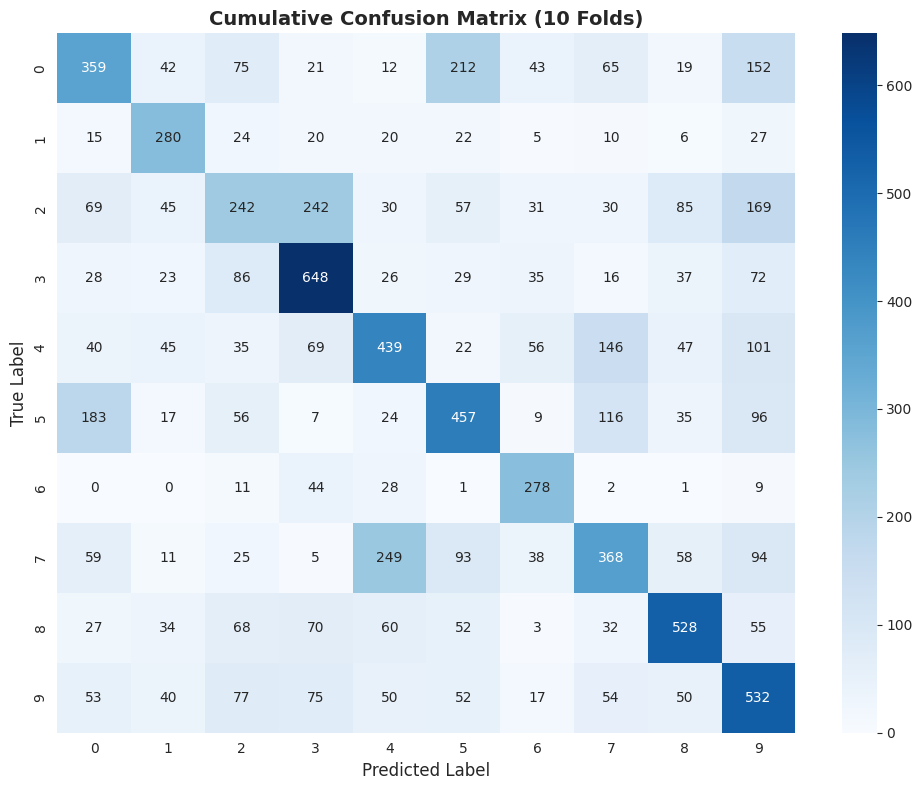

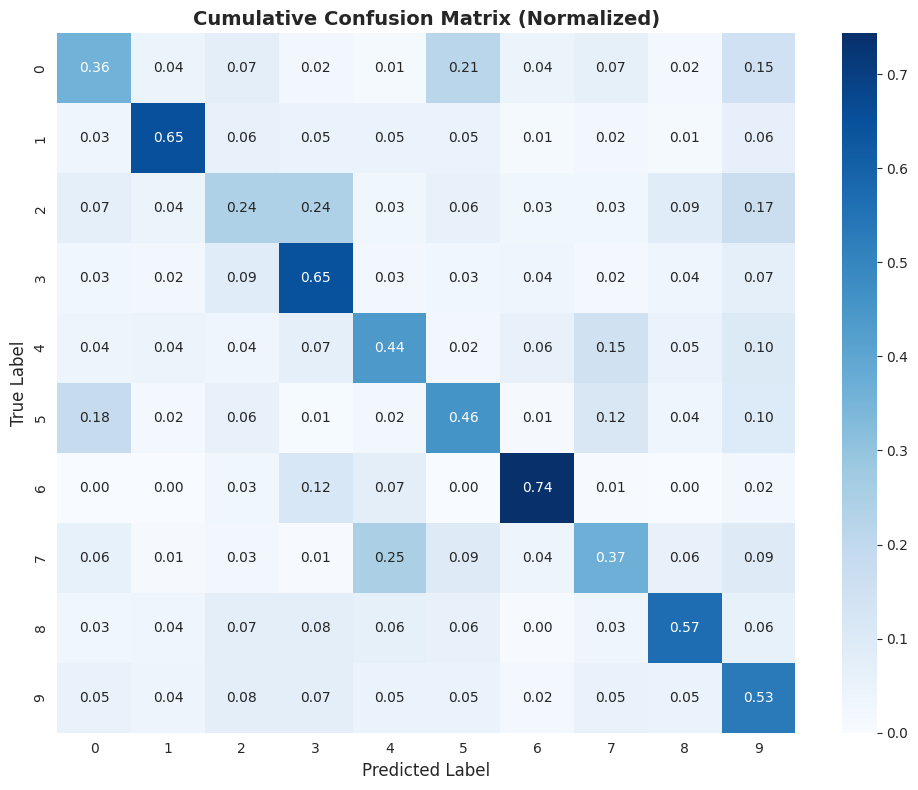

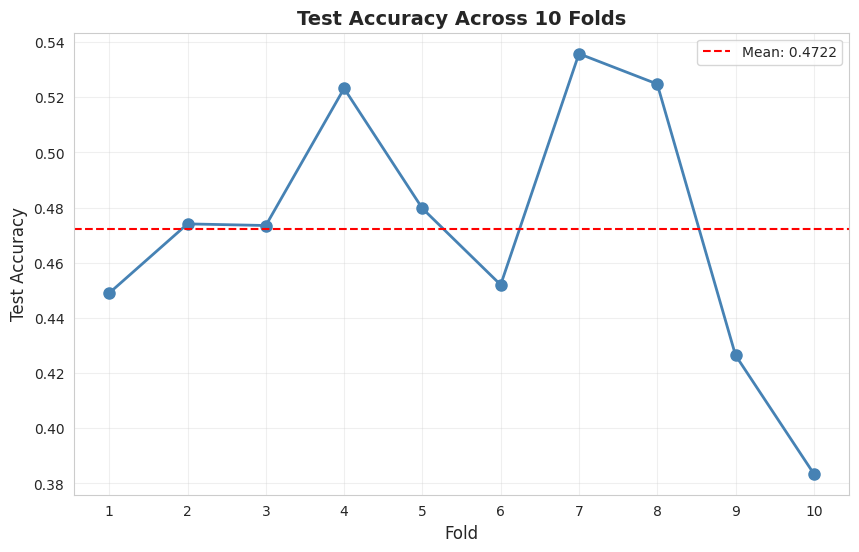

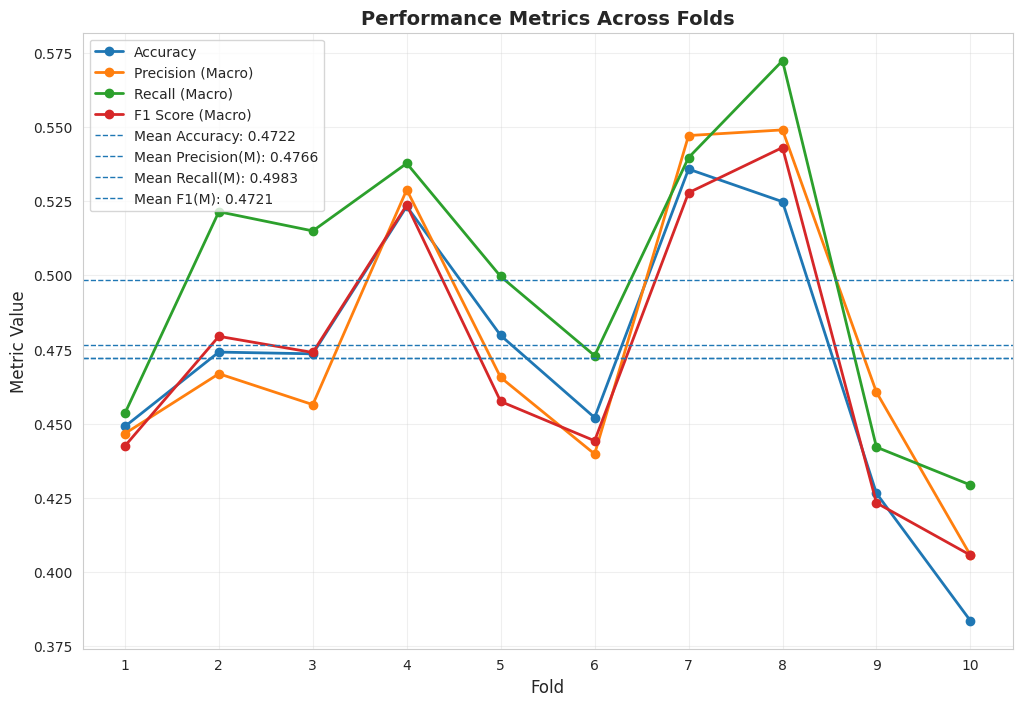


All results saved to: saved_cv/1128_230633
Model saved to: saved_cv/1128_230633


In [20]:
results = train_audio_rnn_cross_validation(
    data_cache_dir=data_cache_dir,
    config=config,
    epochs=20,
    batch_size=16,
    lr=0.001,
    num_classes=10
)

print(f"Model saved to: {results['save_dir']}")